In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import xarray as xr

In [4]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import loading_utils
from backend import metrics_utils
from backend import return_period_metrics

In [5]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.METRICS_DIR / 'concatenated_return_period_metrics' / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



In [6]:
glofas = pd.concat(
    [precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][0][rp] for rp in [1.01, 2, 5, 10]],
    axis=1
)
glofas

,1.01,2.00,5.00,10.00
GRDC_1104150,0.500000,0.500000,NaN,NaN
GRDC_1104450,0.378947,0.666667,0.666667,0.0
GRDC_1104600,0.514286,0.142857,NaN,NaN
GRDC_1104800,0.482051,0.800000,1.000000,1.0
GRDC_1107700,0.525000,0.461538,0.833333,0.0
...,...,...,...,...
GRDC_6984500,0.350000,0.333333,0.000000,0.0
GRDC_6984700,0.333333,0.250000,NaN,NaN
GRDC_6984800,NaN,NaN,NaN,NaN
GRDC_6987050,NaN,NaN,NaN,NaN


In [7]:
# precisions: [3652, 3688, 3528, 3278]
# recalls: [3682, 3691, 3598, 3328]
[glofas[col].dropna().shape[0] for col in glofas]

[3652, 3688, 3528, 3278]

In [8]:
missing_gauges_recalls = ['GRDC_3179670',
 'GRDC_1159120',
 'GRDC_3179650',
 'GRDC_1160373',
 'GRDC_4123252',
 'GRDC_1160523',
 'GRDC_4115226',
 'GRDC_6794200',
 'GRDC_4150462',
 'GRDC_1160500',
 'GRDC_4152110']

missing_gauges_precisions = list(set(glofas[2].dropna().index) - set(glofas[1.01].dropna().index))
len(missing_gauges_precisions)

41

In [9]:
set(missing_gauges_recalls) - (set(missing_gauges_recalls) - set(missing_gauges_precisions))

set()

In [10]:
set(missing_gauges_precisions) - (set(missing_gauges_precisions) - set(missing_gauges_recalls))

set()

In [11]:
missing_gauges = missing_gauges_precisions
glofas_model_runs = loading_utils.load_glofas_model_runs(gauges=missing_gauges)

grdc_observation_data = loading_utils.load_grdc_data()
grdc_observation_data = grdc_observation_data.sel(
    {
        'lead_time': 0,
        'gauge_id': missing_gauges
    }
)
glofas_model_runs = xr.merge([glofas_model_runs, grdc_observation_data])

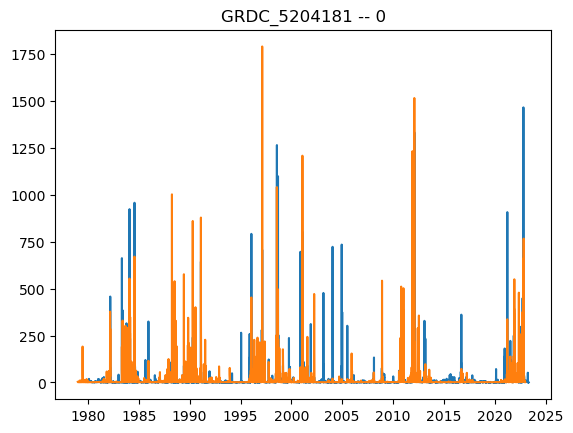

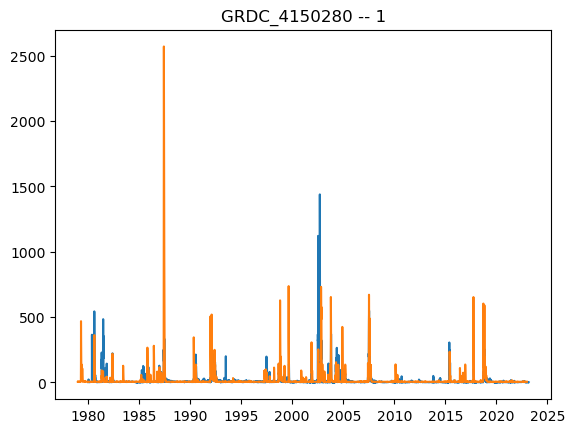

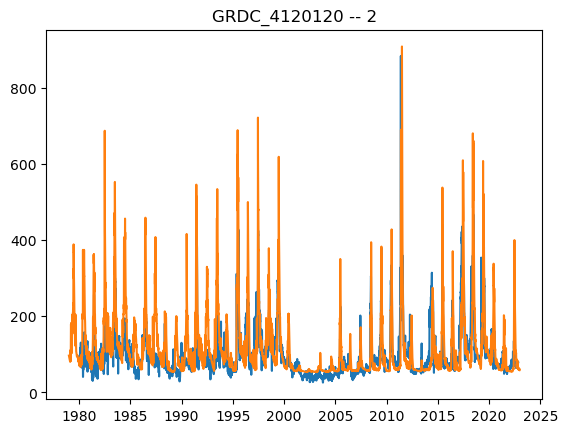

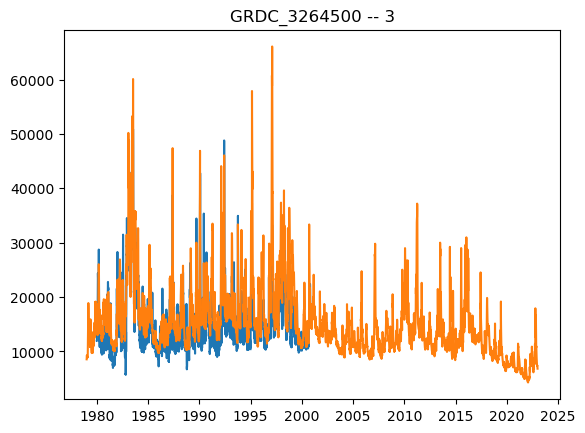

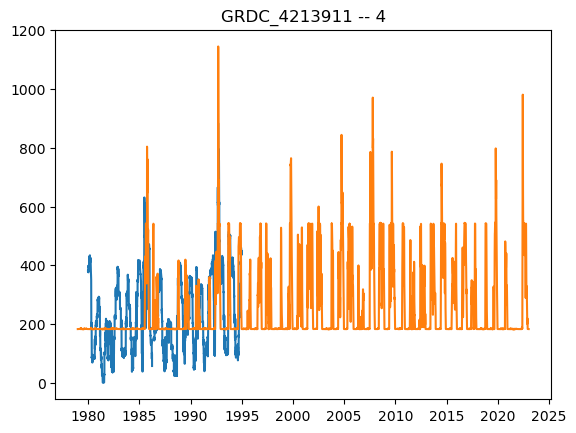

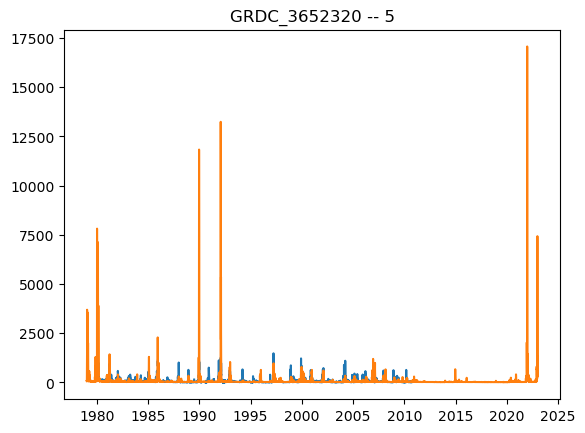

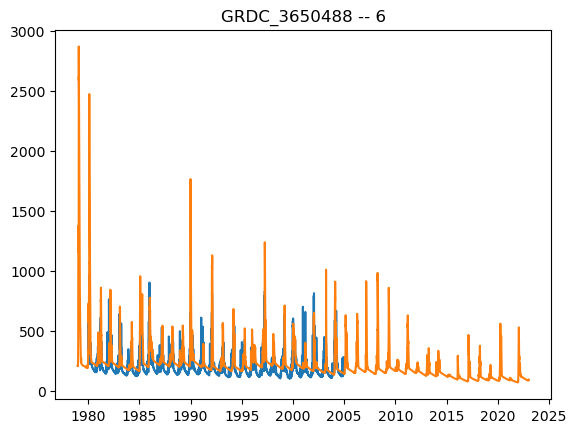

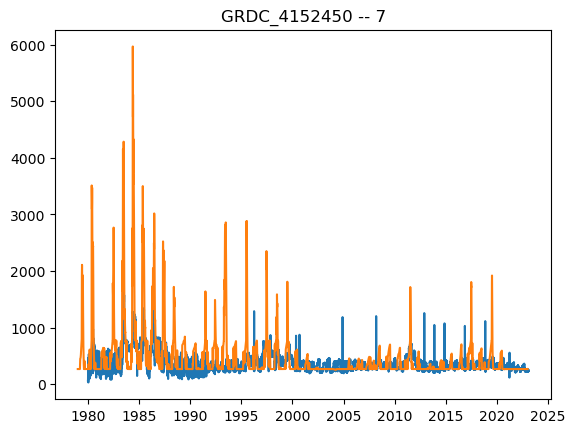

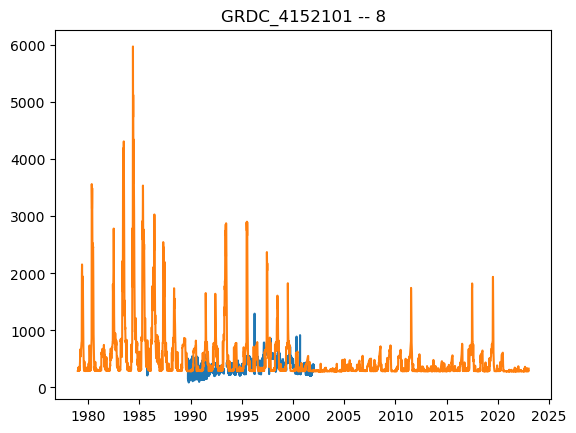

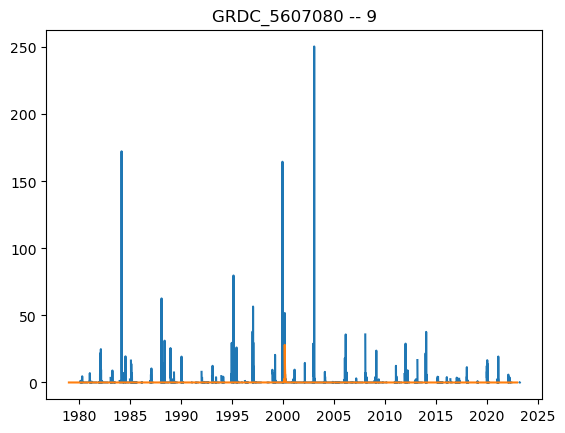

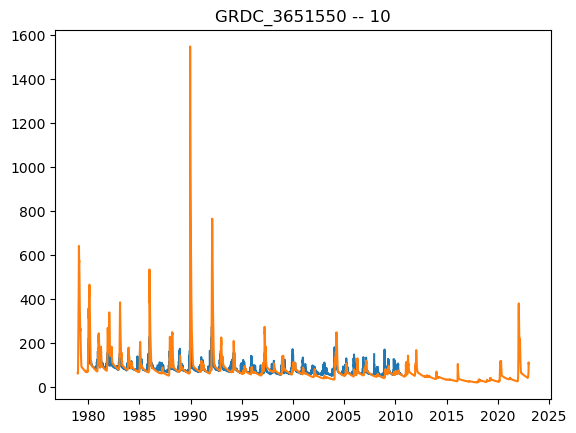

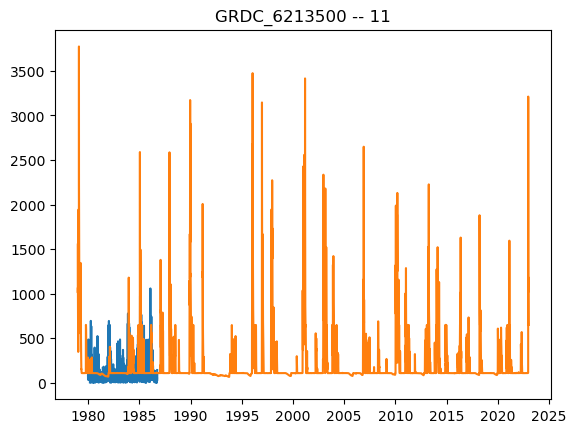

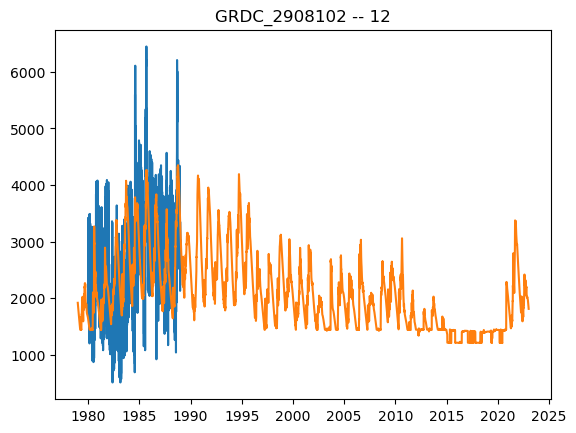

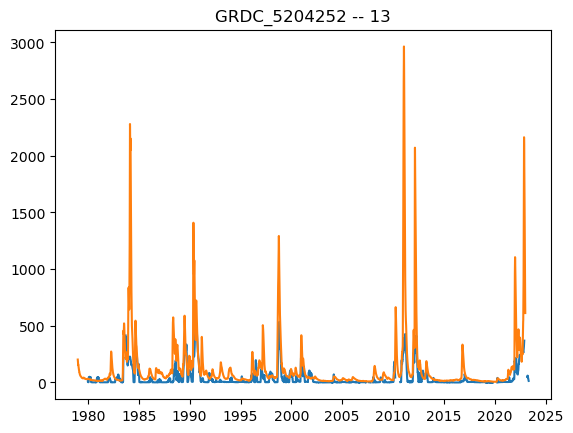

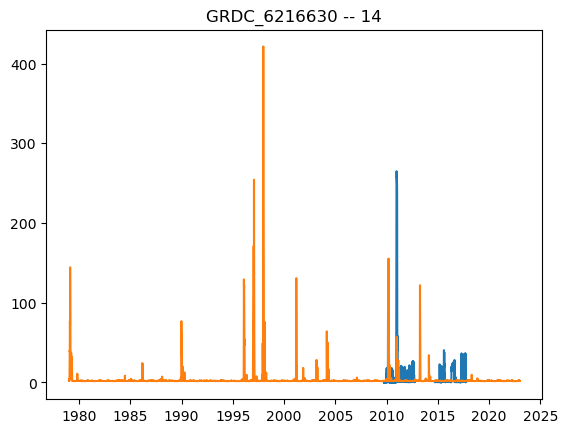

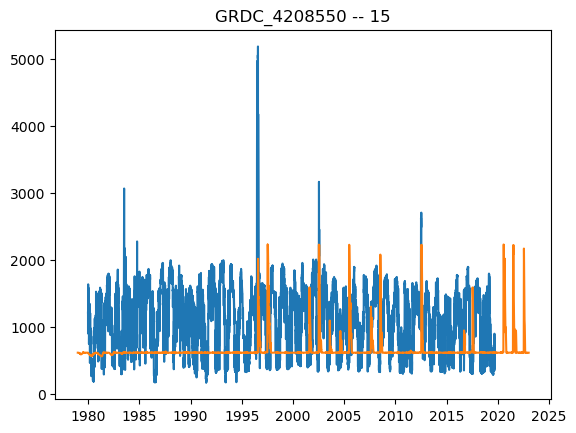

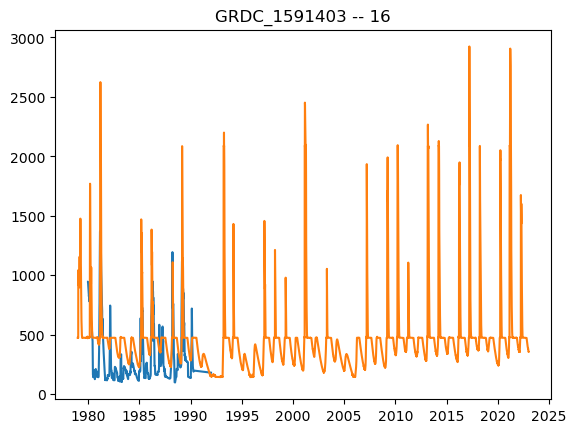

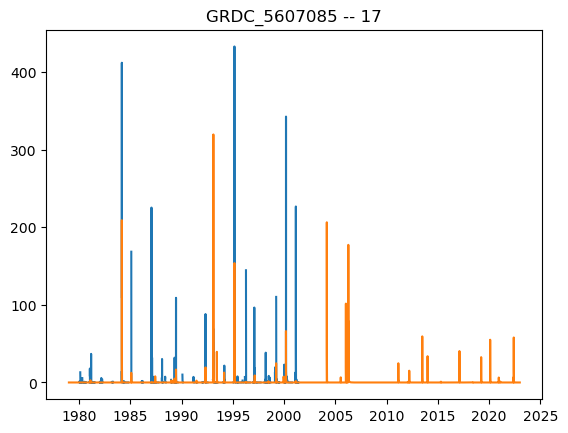

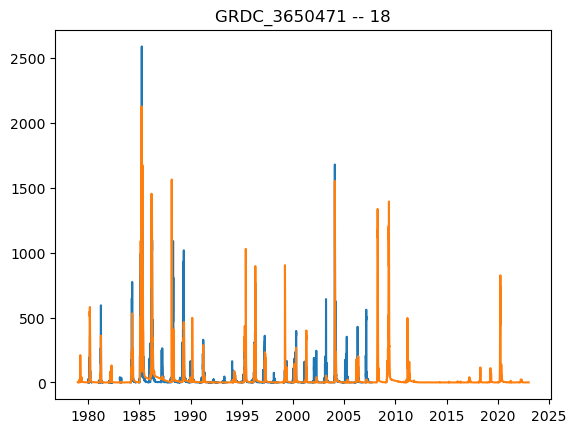

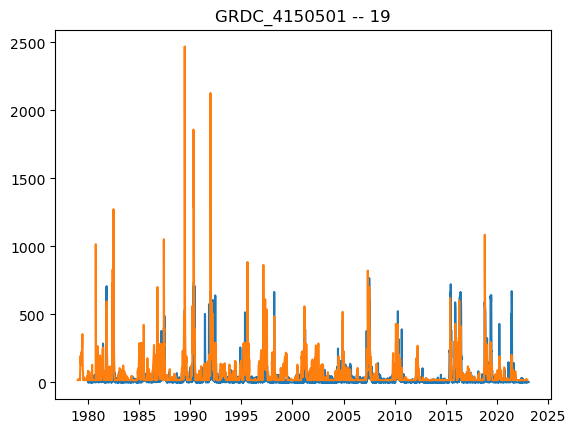

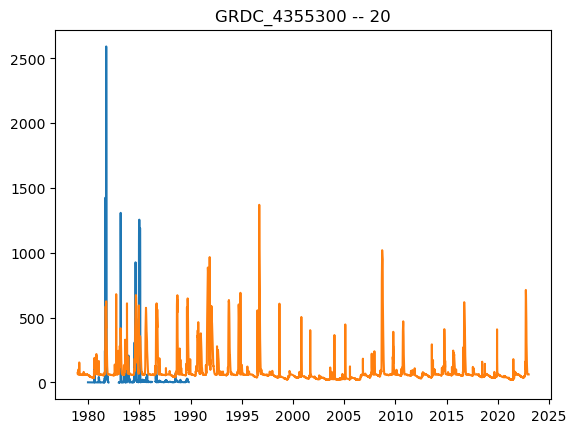

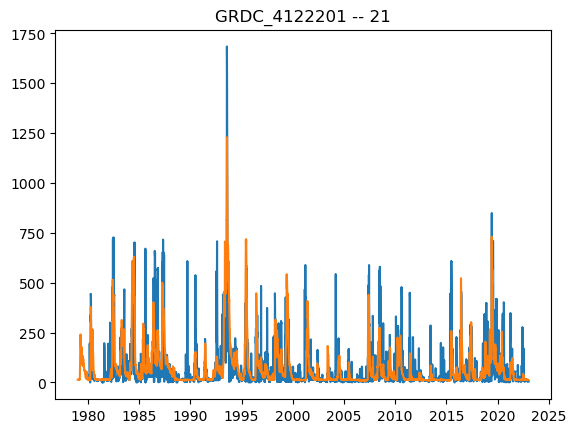

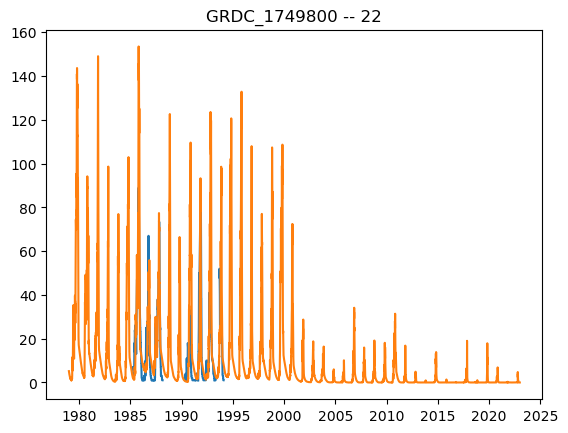

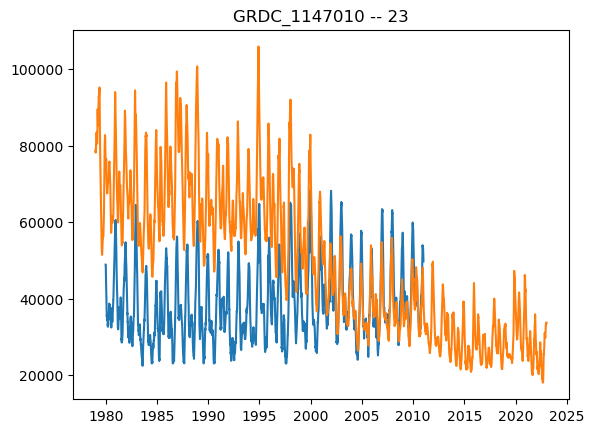

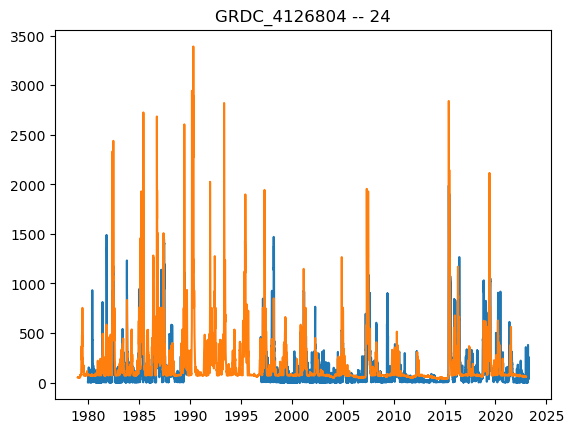

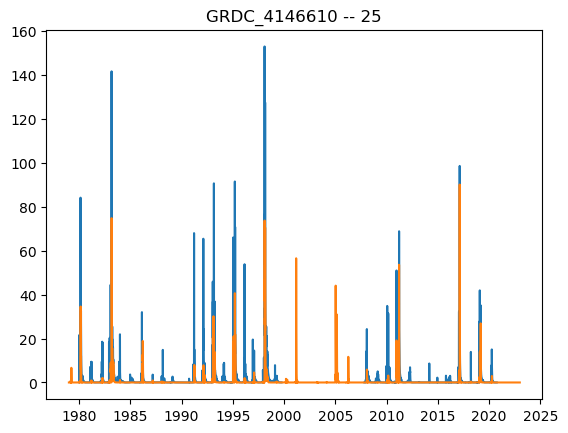

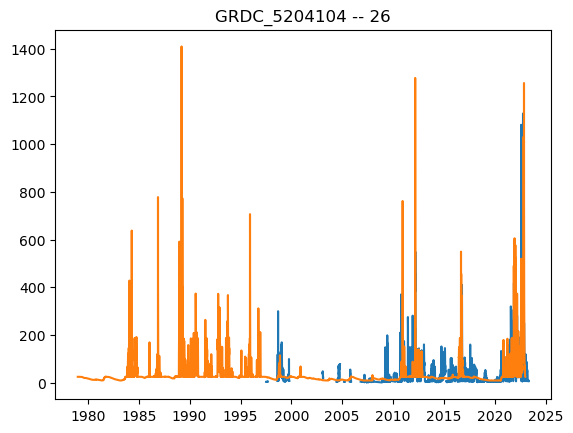

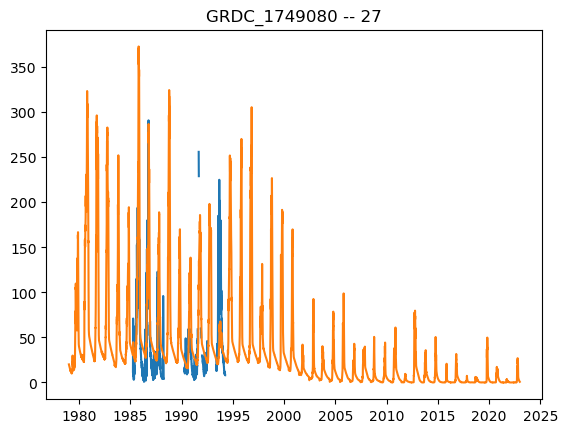

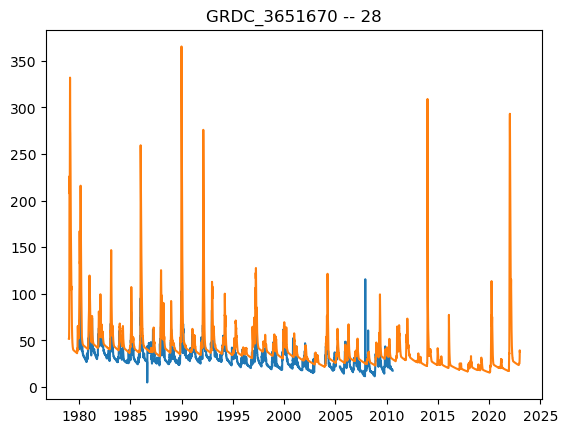

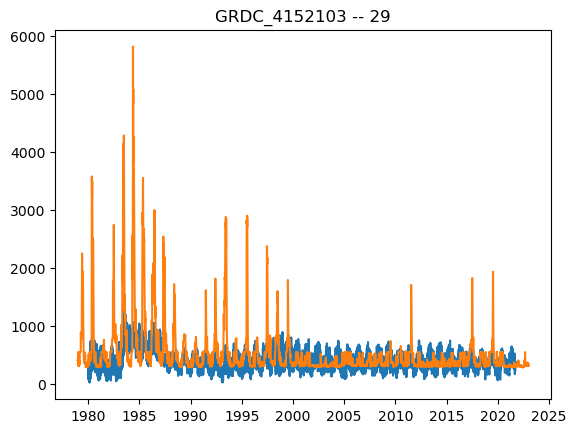

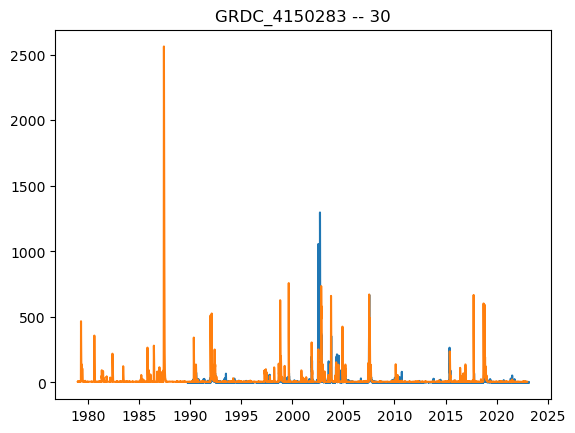

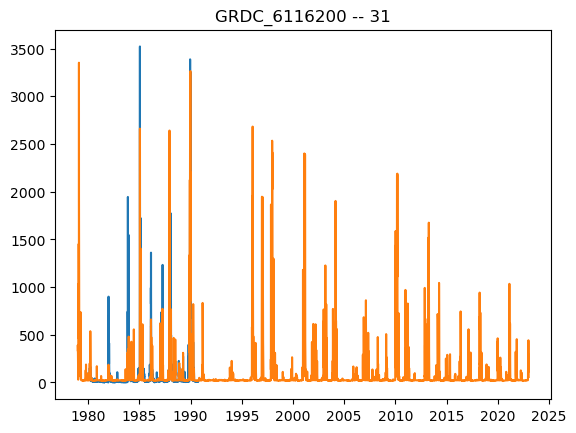

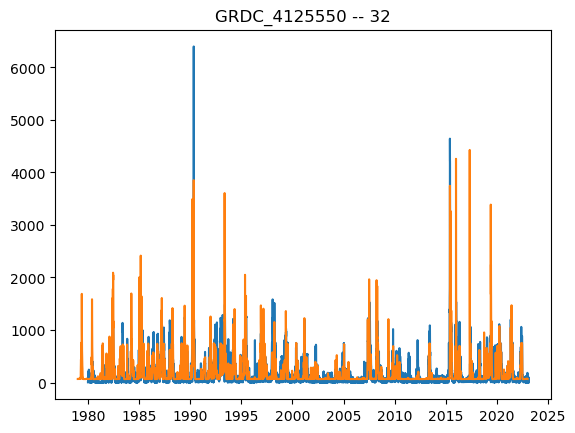

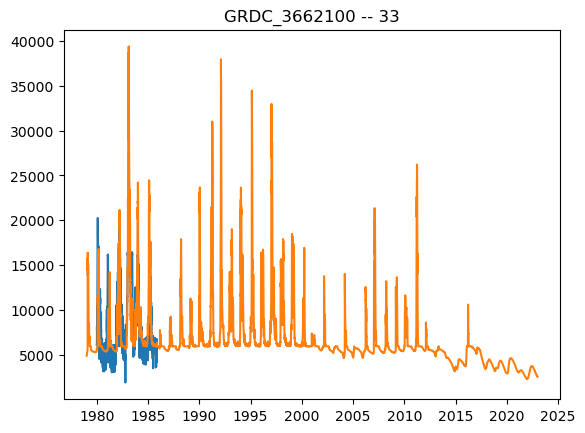

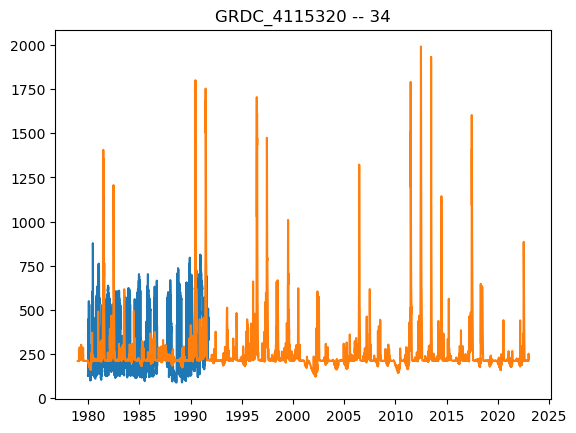

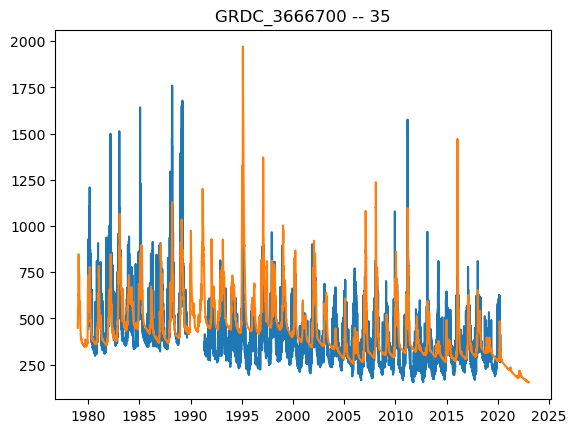

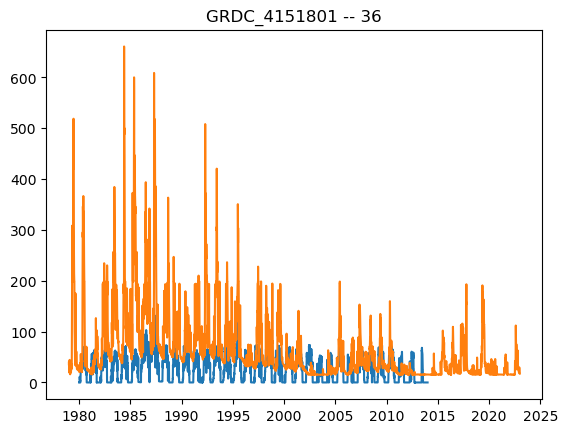

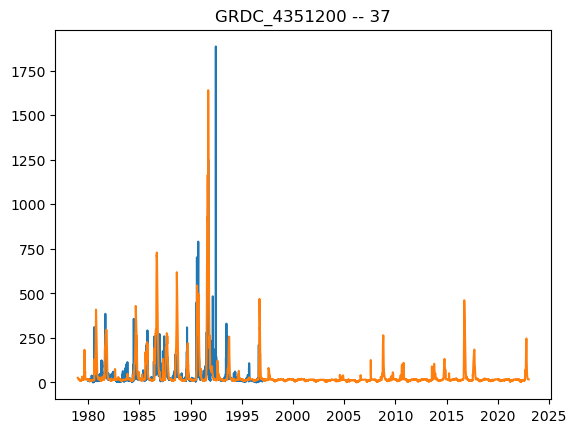

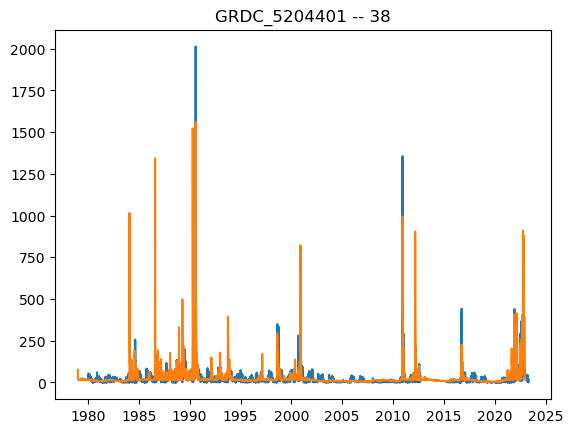

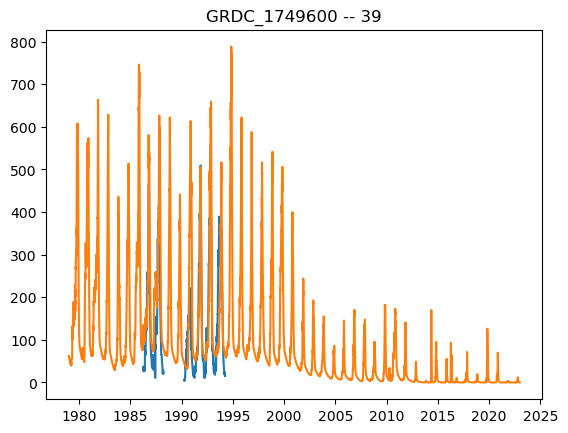

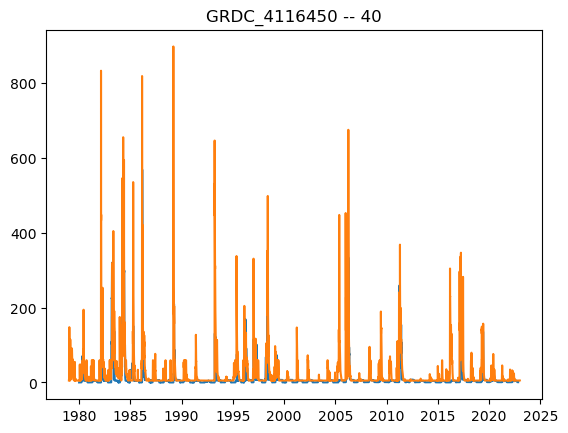

In [12]:
for gauge_idx in range(len(missing_gauges)):
    plt.plot(
        glofas_model_runs.sel({'gauge_id': missing_gauges[gauge_idx]}).time.values,
        glofas_model_runs.sel({'gauge_id': missing_gauges[gauge_idx]}).unnormalized_observation.values
    )

    plt.plot(
        glofas_model_runs.sel({'gauge_id': missing_gauges[gauge_idx]}).time.values,
        glofas_model_runs.sel({'gauge_id': missing_gauges[gauge_idx]}).glofas_prediction.values
    )
    plt.title(f'{missing_gauges[gauge_idx]} -- {gauge_idx}')
    plt.show()

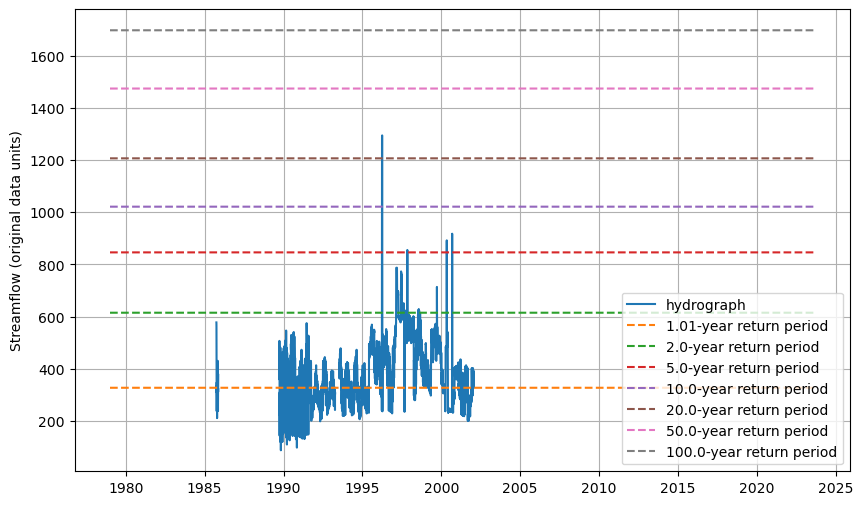

In [13]:
from backend.return_period_calculator import return_period_calculator
rpc = return_period_calculator.ReturnPeriodCalculator(
    hydrograph_series=glofas_model_runs.sel({'gauge_id': missing_gauges[8]}).unnormalized_observation.to_series(),
    hydrograph_series_frequency=pd.Timedelta(1, 'day'),
    use_simple_fitting=True
)
rpc.plot_hydrograph_with_return_periods()

In [14]:
from backend import return_period_metrics
import numpy as np

missing_gauges = missing_gauges_precisions
for gauge in missing_gauges:
    glofas_rp_metrics, _ = return_period_metrics.calculate_return_period_performance_metrics(
        observations=glofas_model_runs.sel({'gauge_id': gauge}).unnormalized_observation.to_series(),
        predictions=glofas_model_runs.sel({'gauge_id': gauge}).glofas_prediction.to_series()
    )
    if any([np.isnan(v) for v in glofas_rp_metrics.values()]):
        asdf

In [15]:
missing_gauges = missing_gauges_recalls
glofas_model_runs = loading_utils.load_glofas_model_runs(gauges=missing_gauges)

grdc_observation_data = loading_utils.load_grdc_data()
grdc_observation_data = grdc_observation_data.sel(
    {
        'lead_time': 0,
        'gauge_id': missing_gauges
    }
)
glofas_model_runs = xr.merge([glofas_model_runs, grdc_observation_data])

In [16]:
from backend import return_period_metrics
import numpy as np

for gauge in missing_gauges:
    glofas_rp_metrics, _ = return_period_metrics.calculate_return_period_performance_metrics(
        observations=glofas_model_runs.sel({'gauge_id': gauge}).unnormalized_observation.to_series(),
        predictions=glofas_model_runs.sel({'gauge_id': gauge}).glofas_prediction.to_series()
    )
    if any([np.isnan(v) for v in glofas_rp_metrics.values()]):
        asdf

In [17]:
asdf

NameError: name 'asdf' is not defined

In [18]:
google = pd.concat(
    [precisions_by_lead_time['google_1980']['full_run'][0][rp] for rp in [1.01, 2, 5, 10]],
    axis=1
)
[google[col].dropna().shape[0] for col in google]

[5052, 5023, 4826, 4521]

In [37]:
google_missing_gauges = list(set(google[2].dropna().index) - set(google[1.01].dropna().index))
print(len(google_missing_gauges))

4


In [72]:
two_better_than_one_gauges = list(google.loc[(google[2] - google[1.01]) > 0].index)
len(two_better_than_one_gauges)

2337

In [31]:
google_model_runs = loading_utils.load_all_experimental_model_runs(
    gauges=two_better_than_one_gauges,
    experiments=['kfold_splits']
)

obs = loading_utils.load_grdc_data()
obs = obs.sel(
    {
        'lead_time': 0,
        'gauge_id': two_better_than_one_gauges
    }
)
google_model_runs = xr.merge([google_model_runs['kfold_splits'], obs])

Working on experiment: kfold_splits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2337/2337 [00:40<00:00, 57.81it/s]


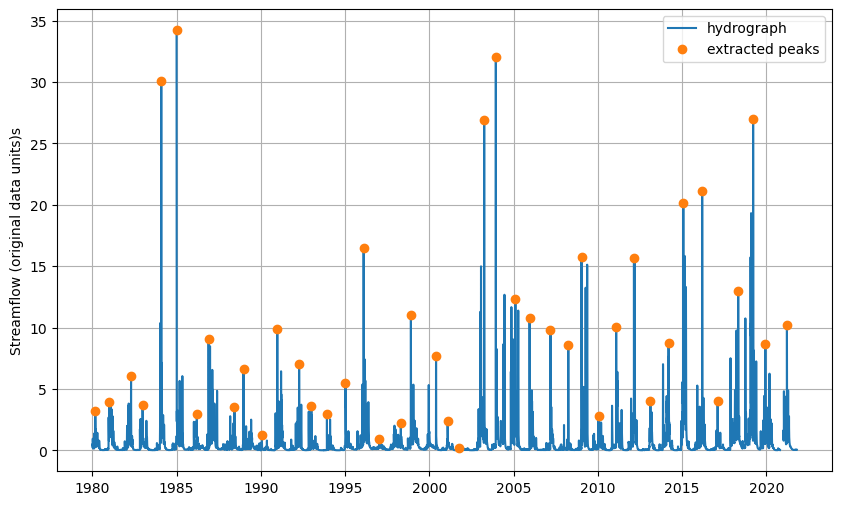

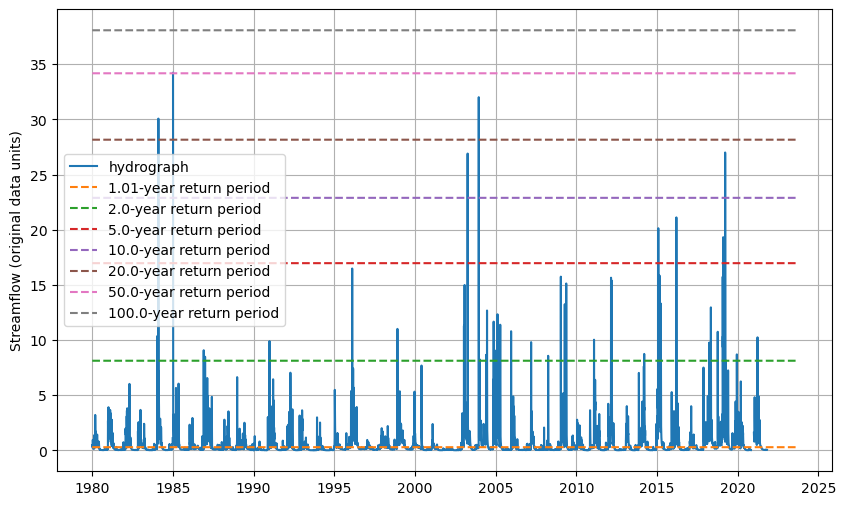

[0.2835407961772027, 8.121235472364036, 16.966074964117134, 22.887966819744367]

In [69]:
gauge = two_better_than_one_gauges[1]
rpc = return_period_calculator.ReturnPeriodCalculator(
    hydrograph_series=google_model_runs.sel({'gauge_id': gauge, 'lead_time': 0}).google_prediction.to_series(),
    hydrograph_series_frequency=pd.Timedelta(1, 'day'),
    use_simple_fitting=True
)
rpc.plot_hydrograph_with_peaks()
rpc.plot_hydrograph_with_return_periods()

thresholds = [rpc.flow_value_from_return_period(rp) for rp in [1.01, 2, 5, 10]]
thresholds

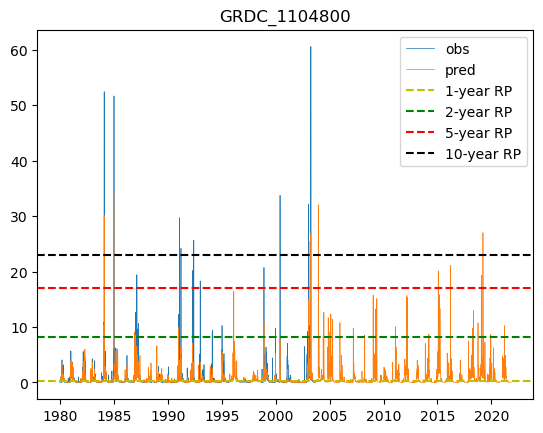

In [71]:
timeslice = google_model_runs.sel({'gauge_id': gauge, 'lead_time': 0}).time.values#[5000:8100]
plt.plot(
    google_model_runs.sel({'gauge_id': gauge, 'lead_time': 0, 'time': timeslice}).time.values,
    google_model_runs.sel({'gauge_id': gauge, 'lead_time': 0, 'time': timeslice}).observation.values,
    label='obs',
    lw=0.5
)

plt.plot(
    google_model_runs.sel({'gauge_id': gauge, 'lead_time': 0, 'time': timeslice}).time.values,
    google_model_runs.sel({'gauge_id': gauge, 'lead_time': 0, 'time': timeslice}).google_prediction.values,
    label='pred',
    lw=0.5
)
plt.axhline(thresholds[0], c='y', ls='--', label='1-year RP')
plt.axhline(thresholds[1], c='g', ls='--', label='2-year RP')
plt.axhline(thresholds[2], c='r', ls='--', label='5-year RP')
plt.axhline(thresholds[3], c='k', ls='--', label='10-year RP')
plt.legend()
plt.title(gauge)
plt.show()

In [ ]:
lead_time = 0
return_period = 1.01
precision_tests = pd.concat(
    [
        precisions_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][return_period].rename('glofas'),
        precisions_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
    ], 
    axis=1
)#.dropna()
precision_tests['glofas']

In [ ]:
missing_gauges_precisions = list(set(glofas[2].dropna().index) - set(glofas[1.01].dropna().index))
len(missing_gauges_precisions)